https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

# Building models with Gaussians

What if we choose to use Gaussian distributions to model our data?

$$p(x|\pi,\Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2}\exp{-\frac{1}{2}(x-\mu)'\Sigma^{-1}(x-\mu)}$$

There would not seem to be any gain doing this, because normal dsitributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:

$$
\begin{eqnarray*}
p(x,y) & = & \mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_x & \Sigma_{xy}\\
\Sigma_{xy}^T & \Sigma_y
\end{array}\right]\right)
\end{eqnarray*}
$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), \Sigma_x - \Sigma_{xy}\Sigma^{-1}_{y}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an inifinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an inifite vector that inly returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a distribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$p(x) \sim GP(m(x), k(x,x'))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$\begin{aligned}
m(x)&=0 \\
k(x, x')&=\theta_1\exp(-\frac{\theta_2}{2}(x-x')^2)
\end{aligned}$$

Here, the covariance function is a squared exponential, for which values of $x$ and $x'$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean of the Gaussian process - surely we can do better than that. It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean function and covariance function, respectively, evaluated at those points.

# Sampling from a GP

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which results in an evaluations of a function over a set of points. All we will do here is a sample from the prior Gaussian process, so before any data has been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

In [1]:
import numpy as np

def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x,y)**2)

We are going to generate realizations sequentially, point by point, using the conditioning property of multivariate Gaussian. Here is the conditional


$$
\begin{eqnarray*}
p(x,y) & =  \mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_x & \Sigma_{xy}\\
\Sigma_{xy}^T & \Sigma_y
\end{array}\right]\right)
\end{eqnarray*}
$$

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), \Sigma_x - \Sigma_{xy}\Sigma^{-1}_{y}\Sigma_{xy}^T)$$

To simplify,

$$
\begin{eqnarray*}
p(x,y) & = & \mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
A & B\\
C & D
\end{array}\right]\right)
\end{eqnarray*}
$$

$$p(x|y) = \mathcal{N}(\mu_x + BD^{-1}(y-\mu_y), A - BD^{-1}C)$$





In [2]:
def conditional(x_new, x, y, params):
    
    A = exponential_cov(x_new, x_new, params)
    B = exponential_cov(x_new, x, params)
    C = B.T
    D = exponential_cov(x, x, params)
    
    mu = np.linalg.inv(D).dot(B).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(D).dot(C))
    
    return (mu.squeeze(), sigma.squeeze())

We will start with a Gaussian Process prior with hyperparameter $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

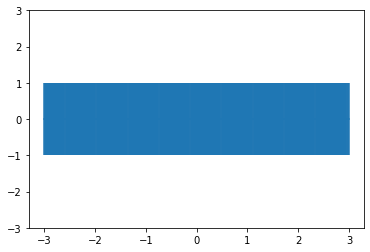

In [6]:
import matplotlib.pyplot as plt

θ = [1,10]
σ_0 = exponential_cov(0,0,θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3);

In [8]:
σ_0

1.0

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no previous points, we can sample from an unconditional Gaussian:

In [7]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[-0.19993452795180194]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$

In [15]:
σ_1 = exponential_cov(x, x, θ)

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3,3,1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x]

[[1.]]


In [11]:
predictions

[(-0.19993452795180194, 0.0)]

In [13]:
x

[1.0]